<a href="https://www.bigdatauniversity.com"><img src="https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width="400" align="center"></a>

<h1 align="center"><font size="5">Classification with Python</font></h1>

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [2]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2019-04-16 11:11:44--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.193
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

100%[======================================>] 23,101      --.-K/s   in 0.09s   

2019-04-16 11:11:45 (264 KB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File  

In [3]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [4]:
df.shape

(346, 10)

### Convert to date time object 

In [5]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [6]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [7]:
# notice: installing seaborn might takes a few minutes
#!conda install -c anaconda seaborn -y

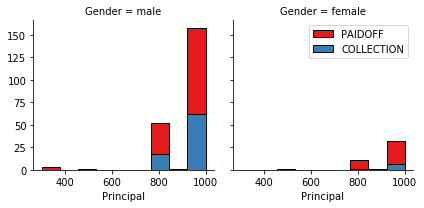

In [8]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

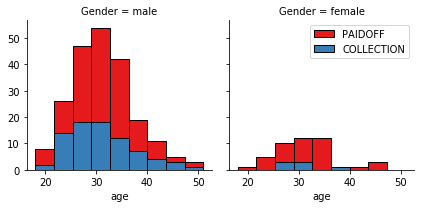

In [9]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

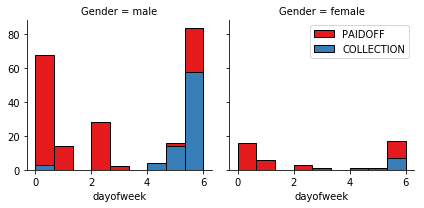

In [10]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [11]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

Lets look at gender:

In [12]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [13]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding  
#### How about education?

In [14]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature before One Hot Encoding

In [15]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to convert categorical varables to binary variables and append them to the feature Data Frame 

In [16]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection

Lets defind feature sets, X:

In [17]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?

In [18]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'], dtype=object)

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [19]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

# K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

In [20]:
# Import the library for splitting the data into train and test set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)

print ('the shape of the features train set:', X_train.shape,', the shape of the target train set:' ,y_train.shape)
print ('the shape of the feature test set:', X_test.shape,', the shape of the target test set:',y_test.shape)

the shape of the features train set: (276, 8) , the shape of the target train set: (276,)
the shape of the feature test set: (70, 8) , the shape of the target test set: (70,)


#### Building the KNN models by assigning the value of K from 1 to 10

In [21]:
# Importing the KNN model
from sklearn.neighbors import KNeighborsClassifier

# Importing the metrics
from sklearn import metrics

Ks = 10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)

    
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

mean_acc

array([ 0.67142857,  0.65714286,  0.71428571,  0.68571429,  0.75714286,
        0.71428571,  0.78571429,  0.75714286,  0.75714286])

#### Plot model accuracy for different number of Neighbors

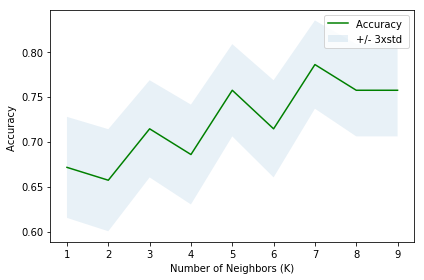

In [22]:
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

In [23]:
print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1) 

The best accuracy was with 0.785714285714 with k= 7


### Build the KNN model with k = 7

In [24]:
# Set value of k as 7
k = 7

# Train Model and Predict  
loanknn = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
loanknn

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=7, p=2,
           weights='uniform')

#### Using the model to predict the test set

In [25]:
yhat = loanknn.predict(X_test)
yhat[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'], dtype=object)

#### Calculating the train and test accuracy

In [26]:
print("Train set Accuracy: ", metrics.accuracy_score(y_train, loanknn.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat))

Train set Accuracy:  0.807971014493
Test set Accuracy:  0.785714285714


#### Building the confusion matrix

In [27]:
from sklearn.metrics import classification_report

print (classification_report(y_test, yhat))

             precision    recall  f1-score   support

 COLLECTION       0.50      0.40      0.44        15
    PAIDOFF       0.84      0.89      0.87        55

avg / total       0.77      0.79      0.78        70



In [28]:
from sklearn.metrics import f1_score
f1_score(y_test, yhat, average='weighted') 

0.77665402444163512

In [29]:
from sklearn.metrics import jaccard_similarity_score
jaccard_similarity_score(y_test, yhat)

0.7857142857142857

# Decision Tree

In [30]:
# Import the decision tree model

from sklearn.tree import DecisionTreeClassifier

#### Decision Tree Modelling

- Build the decision tree model
- Train the model with different max depth ranging from 1 to 10
- Calculate the accuracy of each model

In [31]:
md = 10
mean_acc = np.zeros((md-1))
std_acc = np.zeros((md-1))
ConfustionMx = [];
for n in range(1,md):
    
    #Train Model and Predict  
    loant = DecisionTreeClassifier(criterion="entropy", max_depth = n).fit(X_train,y_train)
    yhat=loant.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)

    
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

mean_acc

array([ 0.78571429,  0.78571429,  0.61428571,  0.61428571,  0.64285714,
        0.77142857,  0.75714286,  0.75714286,  0.65714286])

#### Plot model accuracy for different number of max depth

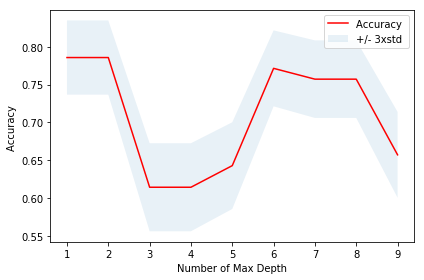

In [32]:
plt.plot(range(1,md),mean_acc,'r')
plt.fill_between(range(1,md),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Max Depth')
plt.tight_layout()
plt.show()

If you set max_depth too high, then the decision tree might simply overfit the training data without capturing useful patterns as we would like; this will cause testing error to increase. But if you set it too low, that is not good as well; then you might be giving the decision tree too little flexibility to capture the patterns and interactions in the training data. This will also cause the testing error to increase. 

There is a nice golden spot in between the extremes of too-high and too-low. Usually, the modeller would consider the max_depth as a hyper-parameter, and use some sort of grid/random search with cross-validation to find a good number for max_depth.

#### Hence, we can conclude that the accuracy of the decision tree classifier is the best when max depth is 6 with an accuracy of 77.14%

### Building the decision tree with max depth of 6

In [33]:
loandt = DecisionTreeClassifier(criterion="entropy", max_depth = 6)

# Check the default parameters
loandt 

# Train the Decision tree model
loandt.fit(X_train,y_train)

# Predict using the model
yhat= loandt.predict(X_test)

#### Calculating the train and test accuracy

In [34]:
print("Train set Accuracy: ", metrics.accuracy_score(y_train, loandt.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat))

Train set Accuracy:  0.775362318841
Test set Accuracy:  0.771428571429


#### Building the confusion matrix

In [35]:
print (classification_report(y_test, yhat))

             precision    recall  f1-score   support

 COLLECTION       0.33      0.07      0.11        15
    PAIDOFF       0.79      0.96      0.87        55

avg / total       0.69      0.77      0.71        70



In [36]:
# Calculate the F1 score
f1_score(y_test, yhat, average='weighted') 

0.70647931303668987

In [37]:
# Calculate the jaccard index
jaccard_similarity_score(y_test, yhat)

0.77142857142857146

#### Visualize the Decison tree

In [38]:
#!conda install -c conda-forge pydotplus -y
#!conda install -c conda-forge python-graphviz -y

In [39]:
'''from sklearn.externals.six import StringIO
import pydotplus
import matplotlib.image as mpimg
from sklearn import tree
%matplotlib inline '''

'from sklearn.externals.six import StringIO\nimport pydotplus\nimport matplotlib.image as mpimg\nfrom sklearn import tree\n%matplotlib inline '

In [40]:
'''dot_data = StringIO()
filename = "loantree.png"
featureNames = Feature.columns
targetNames = df['loan_status'].unique().tolist()
out=tree.export_graphviz(loandt,feature_names=featureNames, out_file=dot_data, class_names= np.unique(y_train), filled=True,  special_characters=True,rotate=False)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png(filename)
img = mpimg.imread(filename)
plt.figure(figsize=(100, 200))
plt.imshow(img,interpolation='nearest')'''

'dot_data = StringIO()\nfilename = "loantree.png"\nfeatureNames = Feature.columns\ntargetNames = df[\'loan_status\'].unique().tolist()\nout=tree.export_graphviz(loandt,feature_names=featureNames, out_file=dot_data, class_names= np.unique(y_train), filled=True,  special_characters=True,rotate=False)  \ngraph = pydotplus.graph_from_dot_data(dot_data.getvalue())  \ngraph.write_png(filename)\nimg = mpimg.imread(filename)\nplt.figure(figsize=(100, 200))\nplt.imshow(img,interpolation=\'nearest\')'

# Support Vector Machine

#### Using the 4 different kernels ffor the SVM classifier to identify the best kernel. 

In [41]:
# Import the library for SVM Classifier
from sklearn import svm

# Build a SVM Classifier with a Radial base Function Kernel
loansvm1 = svm.SVC(kernel='rbf').fit(X_train, y_train)
yhat1 = loansvm1.predict(X_test)
svm_r = metrics.accuracy_score(y_test, yhat1)

# Build a SVM Classifier with a Linear Kernel
loansvm2 = svm.SVC(kernel='linear').fit(X_train, y_train)
yhat2 = loansvm2.predict(X_test)
svm_l = metrics.accuracy_score(y_test, yhat2)
    
# Build a SVM Classifier with a Polynomial Kernel
loansvm3 = svm.SVC(kernel='poly').fit(X_train, y_train)
yhat3 = loansvm3.predict(X_test)
svm_p = metrics.accuracy_score(y_test, yhat3)

# Build a SVM Classifier with a Sigmoid Kernel
loansvm4 = svm.SVC(kernel='sigmoid').fit(X_train, y_train)
yhat4 = loansvm4.predict(X_test)
svm_s = metrics.accuracy_score(y_test, yhat4)
    
print(svm_r,svm_l,svm_p,svm_s)

0.742857142857 0.785714285714 0.771428571429 0.742857142857


#### The SVM with a linear kernel has the highest accuracy (78.57%) followed by the polynomial kernel (77.14%)  

In [42]:
# Find if labels are missing in the SVM models 
print("The label missing in the first model with rbf kernel",set(y_test) - set(yhat1))
print("The label missing in the second model with linear",set(y_test) - set(yhat2))
print("The label missing in the third model with polynomial kernel",set(y_test) - set(yhat3))
print("The label missing in the fourth model with sigmoid kernel",set(y_test) - set(yhat4))


The label missing in the first model with rbf kernel set()
The label missing in the second model with linear {'COLLECTION'}
The label missing in the third model with polynomial kernel set()
The label missing in the fourth model with sigmoid kernel set()


#### The predicted values of the SVM classifiers with a linear and polynomial kernel has predicted all the values as paid off and ignored collection hence these wont be a good model.

### The SVM with the Radial base function and sigmoid kernel have the same accuracy (74.28%) and the models predicted the value collection as well, we conclude the that the rbf kernel is the best

###  SVM Classifier with Radial base function kernel 


In [43]:
# Build and train the SVM Classifier with a linear kernel

loansvm = svm.SVC(kernel='rbf').fit(X_train, y_train) 

#### Predicting the test values using the SVM model

In [44]:
yhat = loansvm.predict(X_test)
yhat [0:5]

array(['COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'], dtype=object)

#### Calculate the train and the test accuracies of the model

In [45]:
print("Train set Accuracy: ", metrics.accuracy_score(y_train, loansvm.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat))

Train set Accuracy:  0.782608695652
Test set Accuracy:  0.742857142857


#### Compute confusion matrix

In [46]:
print (classification_report(y_test, yhat))

             precision    recall  f1-score   support

 COLLECTION       0.36      0.27      0.31        15
    PAIDOFF       0.81      0.87      0.84        55

avg / total       0.72      0.74      0.73        70



#### Calculating the f1 score

In [47]:
# Calculate the f1 score
f1_score(y_test, yhat, average='weighted') 

0.72758820127241175

#### Calculating the Jaccard similarity score

In [48]:
#Calculate the Jaccard index
jaccard_similarity_score(y_test, yhat)

0.74285714285714288

# Logistic Regression

#### Identifying whci solver in the logistic regreesion has the highes accuracy 

In [49]:
# Import the library for Logistice regression
from sklearn.linear_model import LogisticRegression

# Build and train the logestic regression model
loanlr1 = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
yhat1 = loanlr1.predict(X_test)
loanlr_a1 = metrics.accuracy_score(y_test, yhat1)

# Build and train the logestic regression model
loanlr2 = LogisticRegression(C=0.01, solver='sag').fit(X_train,y_train)
yhat2 = loanlr2.predict(X_test)
loanlr_a2 = metrics.accuracy_score(y_test, yhat2)

# Build and train the logestic regression model
loanlr3 = LogisticRegression(C=0.01, solver='saga').fit(X_train,y_train)
yhat3 = loanlr3.predict(X_test)
loanlr_a3 = metrics.accuracy_score(y_test, yhat3)

# Build and train the logestic regression model
loanlr4 = LogisticRegression(C=0.01, solver='newton-cg').fit(X_train,y_train)
yhat4 = loanlr4.predict(X_test)
loanlr_a4 = metrics.accuracy_score(y_test, yhat4)

# Build and train the logestic regression model
loanlr5 = LogisticRegression(C=0.01, solver='lbfgs').fit(X_train,y_train)
yhat5 = loanlr5.predict(X_test)
loanlr_a5 = metrics.accuracy_score(y_test, yhat5)


print('LR model with liblinear solver',loanlr_a1)
print('LR model with sag solver',loanlr_a2)
print('LR model with saga solver',loanlr_a3)
print('LR model with newton-cg solver',loanlr_a4)
print('LR model with lbfgs solver',loanlr_a5)

LR model with liblinear solver 0.685714285714
LR model with sag solver 0.785714285714
LR model with saga solver 0.785714285714
LR model with newton-cg solver 0.785714285714
LR model with lbfgs solver 0.785714285714


In [50]:
# Find if labels are missing in the models 
print("The label missing in the LR model with liblinear solver",set(y_test) - set(yhat1))
print("The label missing in the LR model with sag solver",set(y_test) - set(yhat2))
print("The label missing in the LR model with saga solver",set(y_test) - set(yhat3))
print("The label missing in the LR model with newton-cg solver",set(y_test) - set(yhat4))
print("The label missing in the LR model with lbfgs solver",set(y_test) - set(yhat5))

The label missing in the LR model with liblinear solver set()
The label missing in the LR model with sag solver {'COLLECTION'}
The label missing in the LR model with saga solver {'COLLECTION'}
The label missing in the LR model with newton-cg solver {'COLLECTION'}
The label missing in the LR model with lbfgs solver {'COLLECTION'}


### Except for the liblinear solver all other model has skipped the lable "collection" from the predicted values. Hence, the best logistic classifier will be the one with a liblinear solver.

In [51]:
loanlr = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
yhat = loanlr.predict(X_test)

In [52]:
print("Train set Accuracy: ", metrics.accuracy_score(y_train, loanlr.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat))

Train set Accuracy:  0.757246376812
Test set Accuracy:  0.685714285714


In [53]:
print (classification_report(y_test, yhat))

             precision    recall  f1-score   support

 COLLECTION       0.18      0.13      0.15        15
    PAIDOFF       0.78      0.84      0.81        55

avg / total       0.65      0.69      0.67        70



In [54]:
# Calculate the f1 score
f1_score(y_test, yhat, average='weighted') 

0.66705224599961443

In [55]:
#Calculate the Jaccard index
jaccard_similarity_score(y_test, yhat)

0.68571428571428572

# Model Evaluation using Test set

In [56]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, download and load the test set:

In [57]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2019-04-16 11:11:47--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.193
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

100%[======================================>] 3,642       --.-K/s   in 0s      

2019-04-16 11:11:48 (524 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation 

In [58]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [59]:
# shape of the test data set 
test_df.shape

(54, 10)

In [60]:
# Count of the loan status 
test_df['loan_status'].value_counts()

PAIDOFF       40
COLLECTION    14
Name: loan_status, dtype: int64

### Preprocessing
#### Feature Engineering

In [61]:
df = test_df

df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df['dayofweek'] = df['effective_date'].dt.dayofweek
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)

df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)

df.groupby(['education'])['loan_status'].value_counts(normalize=True)

Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)

X_test = Feature

y_test = df['loan_status'].values

X_test = preprocessing.StandardScaler().fit(X_test).transform(X_test)

### Testing the accuracy of the models with each data 
1. KNN

In [62]:
# KNN model
yhat_knn = loanknn.predict(X_test)

# Calculate the f1 score
f1_knn = f1_score(y_test, yhat_knn, average='weighted') 

#Calculate the Jaccard index# Predict using the model
jsc_knn = jaccard_similarity_score(y_test, yhat_knn)

print('f1 score: ',f1_knn)
print('Jaccard index: ',jsc_knn)

f1 score:  0.632840028189
Jaccard index:  0.666666666667


2. Decison Tree

In [63]:
# Predict using the model
yhat_dt= loandt.predict(X_test)

# Calculate the f1 score
f1_dt = f1_score(y_test, yhat_dt, average='weighted') 

#Calculate the Jaccard index# Predict using the model
jsc_dt = jaccard_similarity_score(y_test, yhat_dt)

print('f1 score: ',f1_dt)
print('Jaccard index: ',jsc_dt)

f1 score:  0.670477692358
Jaccard index:  0.722222222222


3. SVM

In [64]:
# Predict using the model
yhat_svm = loansvm.predict(X_test)

# Calculate the f1 score
f1_svm = f1_score(y_test, yhat_svm, average='weighted') 

#Calculate the Jaccard index# Predict using the model
jsc_svm = jaccard_similarity_score(y_test, yhat_svm)

print('f1 score: ',f1_svm)
print('Jaccard index: ',jsc_svm)

f1 score:  0.758350307729
Jaccard index:  0.796296296296


4. Logistic Regression

In [65]:
# Predict using the model
yhat_lr = loanlr.predict(X_test)

# Calculate the f1 score
f1_lr = f1_score(y_test, yhat_lr, average='weighted') 

#Calculate the Jaccard index# Predict using the model
jsc_lr = jaccard_similarity_score(y_test, yhat_lr)

# Calculate Log loss
yhat_lr_prob = loanlr.predict_proba(X_test)
ll_lr = log_loss(y_test, yhat_lr_prob)


print('f1 score: ',f1_lr)
print('Jaccard index: ',jsc_lr)
print('Log Loss: ',ll_lr)

f1 score:  0.660426731079
Jaccard index:  0.740740740741
Log Loss:  0.567215337991


### Preparing the report

In [66]:
Jaccard = [jsc_knn,jsc_dt,jsc_svm,jsc_lr]
F1_score = [f1_knn,f1_dt,f1_svm,f1_lr]
LogLoss = ['NA','NA','NA',ll_lr]

    
df = {'Algorithm': ['KNN', 'Decistion Tree', 'SVM', 'LogisticRegression'], \
     'Jaccard': Jaccard, 'F1-score': F1_score, 'LogLoss': LogLoss}

Report = pd.DataFrame(data=df, columns=['Algorithm', 'Jaccard', 'F1-score', 'LogLoss'], index=None)
Report



,Algorithm,Jaccard,F1-score,LogLoss
0,KNN,0.666667,0.632840,NA
1,Decistion Tree,0.722222,0.670478,NA
2,SVM,0.796296,0.758350,NA
3,LogisticRegression,0.740741,0.660427,0.567215


# Report
You should be able to report the accuracy of the built model using different evaluation metrics:

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | ?       | ?        | NA      |
| Decision Tree      | ?       | ?        | NA      |
| SVM                | ?       | ?        | NA      |
| LogisticRegression | ?       | ?        | ?       |

<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

<p>Copyright &copy; 2018 <a href="https://cocl.us/DX0108EN_CC">Cognitive Class</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.</p>